In [15]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import torchvision.utils as vutils
import os


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                     
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [4]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


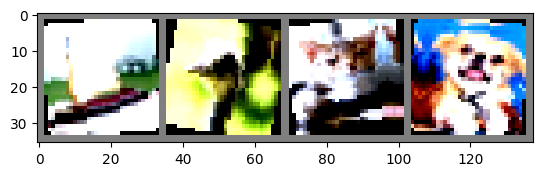

ship  bird  cat   dog  


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [7]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7, 7), padding=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3

        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32/5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16/6/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/10/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/14/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16/14/2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8/16/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = x + self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = x + self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool1(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)        
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [21]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,704
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1

In [31]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    incorrect_examples = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Collect incorrect examples
            incorrect_mask = pred.eq(target.view_as(pred)).squeeze() == 0
            incorrect_examples.extend(data[incorrect_mask])

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
       
    test_acc.append(100. * correct / len(test_loader.dataset))

    # Plot incorrect examples
    fig = plt.figure(figsize=(10, 10))
    for i in range(min(len(incorrect_examples), 10)):
        plt.subplot(5, 5, i + 1)
        plt.tight_layout()
        # Transpose the image tensor to match the format expected by matplotlib
        img = incorrect_examples[i].cpu().numpy().transpose(1, 2, 0)
        # Normalize the image data to the range [0, 1]
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.title("Predicted: {}, Actual: {}".format(pred[i].cpu().numpy(), target[i].cpu().numpy()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

EPOCH: 0


Loss=1.6163753271102905 Batch_id=97 Accuracy=32.85: 100%|██████████| 98/98 [00:16<00:00,  5.92it/s]



Test set: Average loss: 1.6123, Accuracy: 3954/10000 (39.54%)



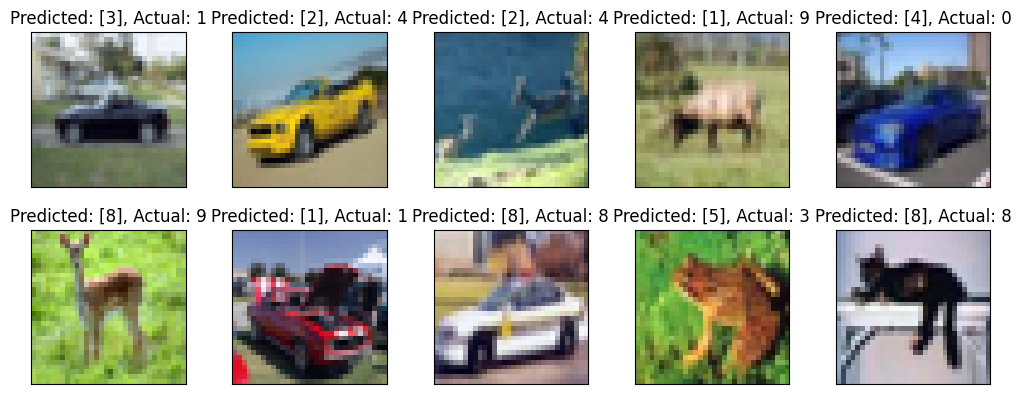

EPOCH: 1


Loss=1.4791340827941895 Batch_id=97 Accuracy=45.05: 100%|██████████| 98/98 [00:16<00:00,  5.93it/s]



Test set: Average loss: 1.3982, Accuracy: 4888/10000 (48.88%)



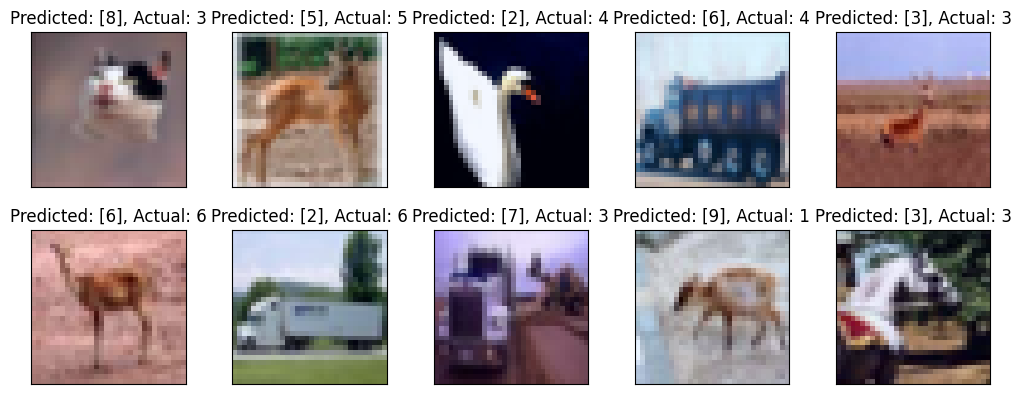

EPOCH: 2


Loss=1.1414023637771606 Batch_id=97 Accuracy=50.95: 100%|██████████| 98/98 [00:16<00:00,  6.07it/s]



Test set: Average loss: 1.3189, Accuracy: 5190/10000 (51.90%)



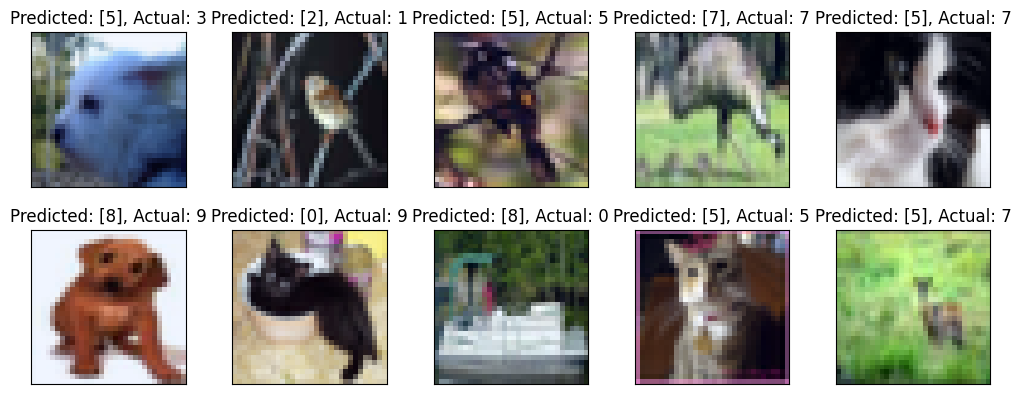

EPOCH: 3


Loss=1.299129605293274 Batch_id=97 Accuracy=54.31: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s] 



Test set: Average loss: 1.1876, Accuracy: 5781/10000 (57.81%)



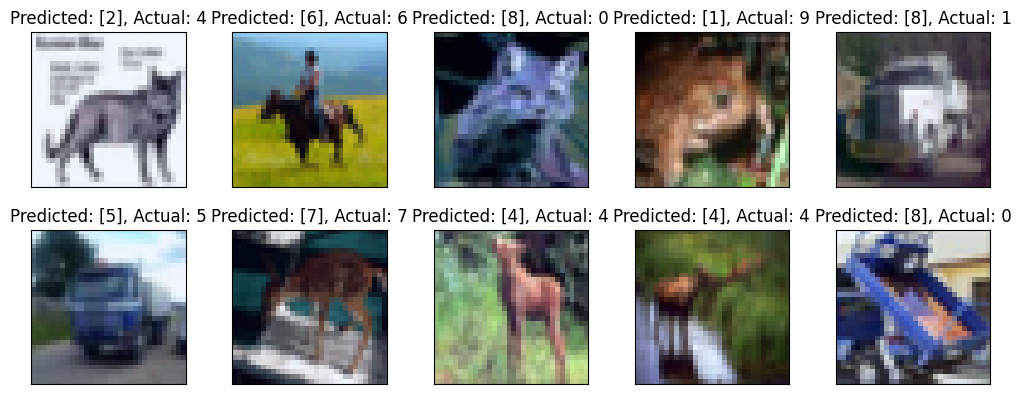

EPOCH: 4


Loss=1.2103408575057983 Batch_id=97 Accuracy=56.87: 100%|██████████| 98/98 [00:16<00:00,  6.06it/s]



Test set: Average loss: 1.1188, Accuracy: 6014/10000 (60.14%)



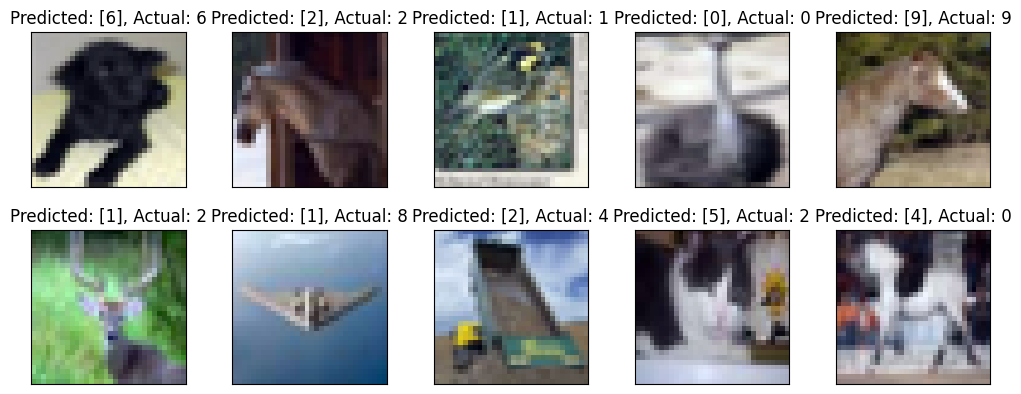

EPOCH: 5


Loss=1.1480247974395752 Batch_id=97 Accuracy=58.63: 100%|██████████| 98/98 [00:16<00:00,  6.08it/s]



Test set: Average loss: 1.1197, Accuracy: 6010/10000 (60.10%)



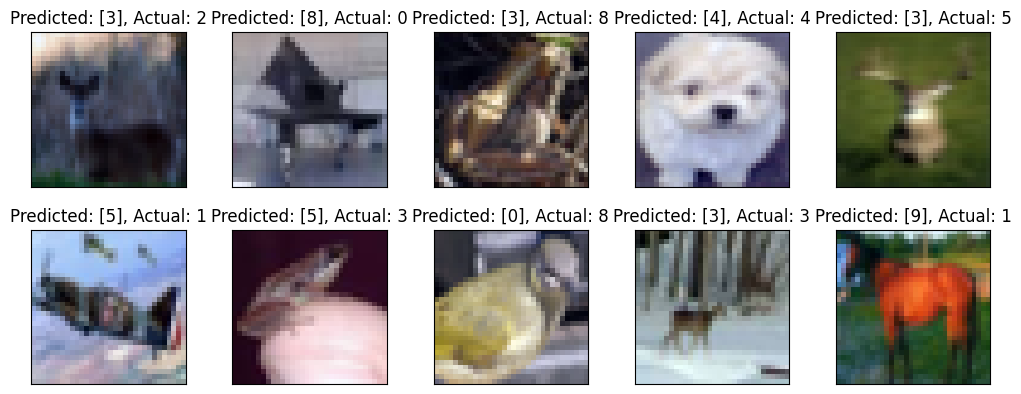

EPOCH: 6


Loss=1.1732038259506226 Batch_id=97 Accuracy=60.43: 100%|██████████| 98/98 [00:17<00:00,  5.66it/s]



Test set: Average loss: 1.0385, Accuracy: 6262/10000 (62.62%)



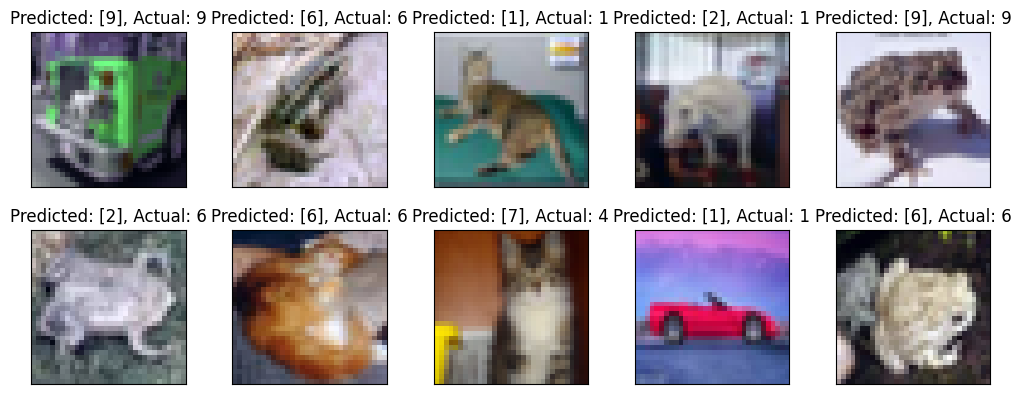

EPOCH: 7


Loss=1.1088427305221558 Batch_id=97 Accuracy=61.13: 100%|██████████| 98/98 [00:16<00:00,  6.05it/s]



Test set: Average loss: 0.9820, Accuracy: 6478/10000 (64.78%)



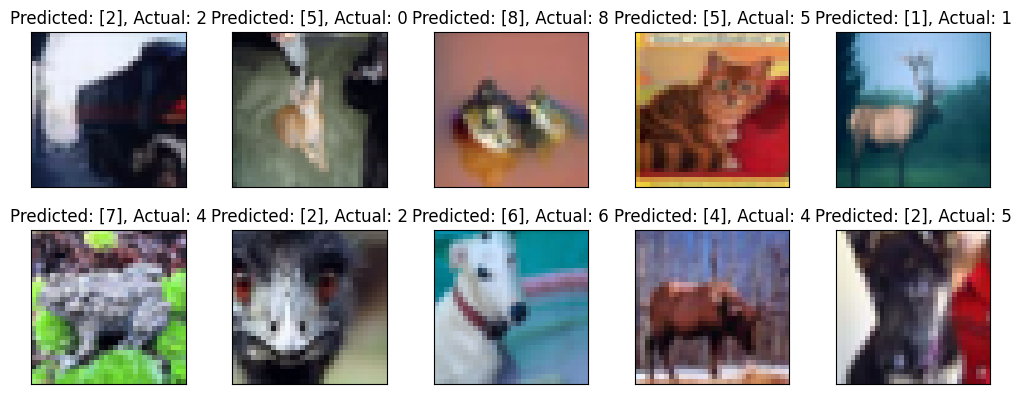

EPOCH: 8


Loss=1.1101816892623901 Batch_id=97 Accuracy=62.25: 100%|██████████| 98/98 [00:16<00:00,  5.80it/s]



Test set: Average loss: 0.9668, Accuracy: 6516/10000 (65.16%)



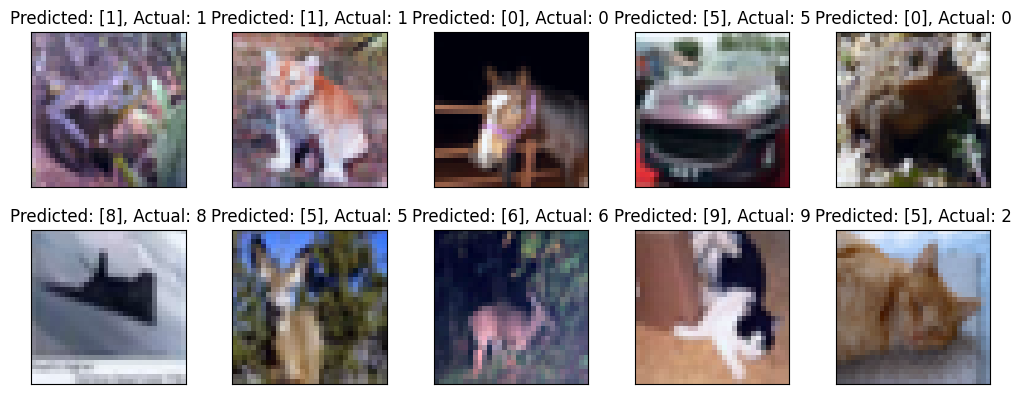

EPOCH: 9


Loss=0.9991987943649292 Batch_id=97 Accuracy=63.12: 100%|██████████| 98/98 [00:16<00:00,  6.06it/s]



Test set: Average loss: 1.0328, Accuracy: 6319/10000 (63.19%)



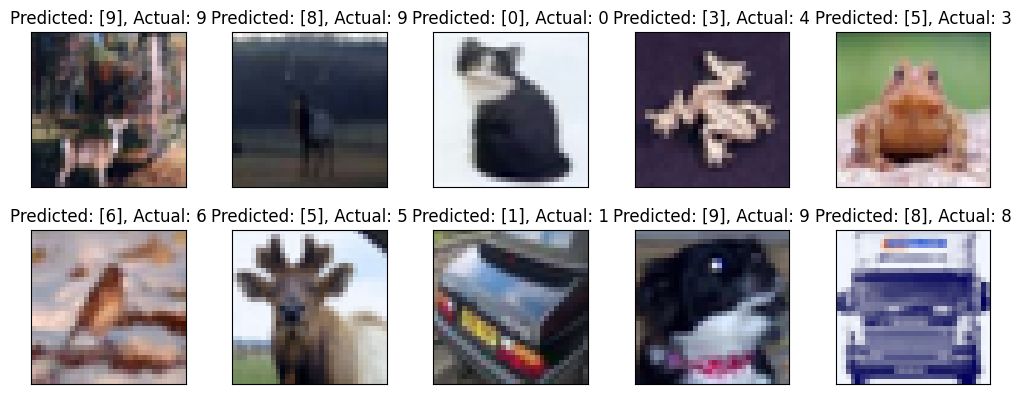

EPOCH: 10


Loss=0.951158344745636 Batch_id=97 Accuracy=64.16: 100%|██████████| 98/98 [00:16<00:00,  6.00it/s] 



Test set: Average loss: 0.9164, Accuracy: 6751/10000 (67.51%)



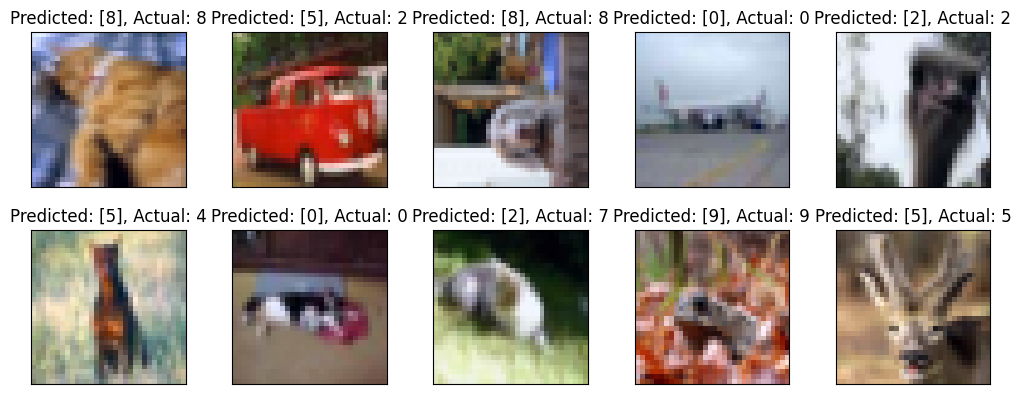

EPOCH: 11


Loss=0.9445212483406067 Batch_id=97 Accuracy=64.55: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]



Test set: Average loss: 0.8784, Accuracy: 6889/10000 (68.89%)



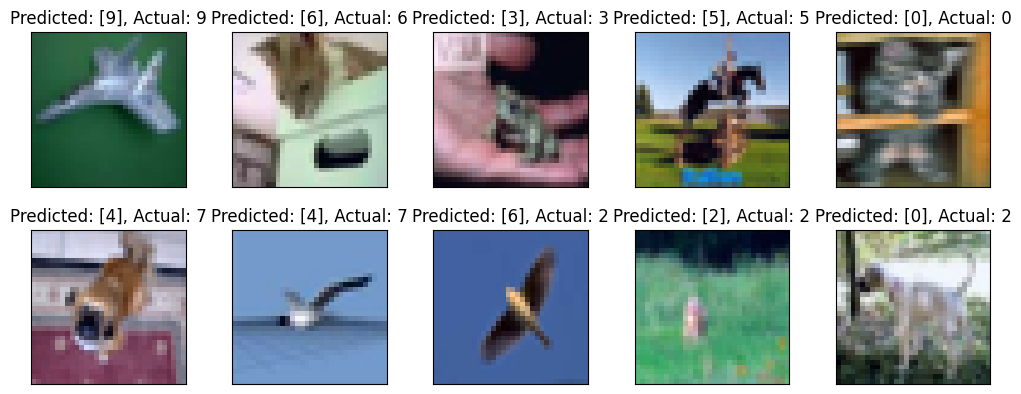

EPOCH: 12


Loss=1.0107845067977905 Batch_id=97 Accuracy=65.49: 100%|██████████| 98/98 [00:16<00:00,  6.05it/s]



Test set: Average loss: 0.8394, Accuracy: 7058/10000 (70.58%)



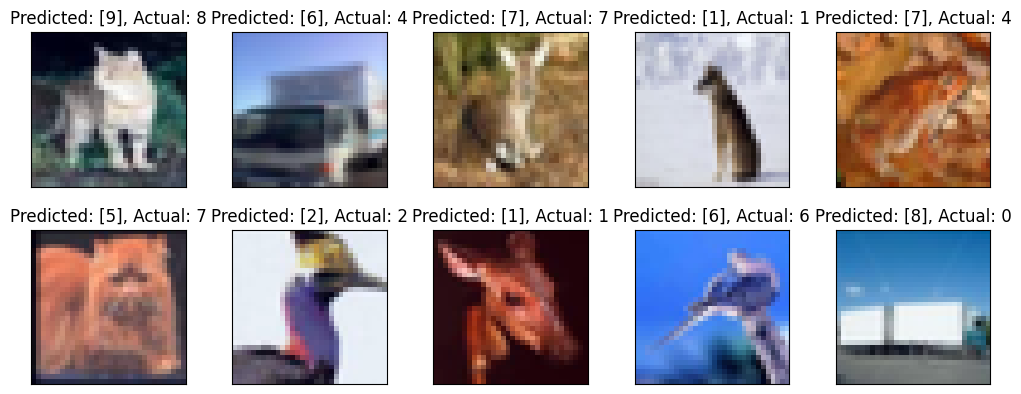

EPOCH: 13


Loss=1.0078383684158325 Batch_id=97 Accuracy=66.02: 100%|██████████| 98/98 [00:16<00:00,  5.86it/s]



Test set: Average loss: 0.8689, Accuracy: 6902/10000 (69.02%)



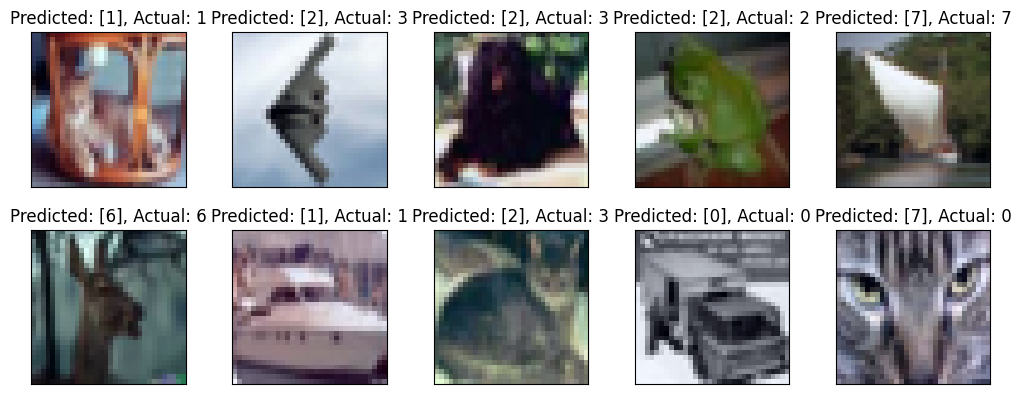

EPOCH: 14


Loss=1.0194249153137207 Batch_id=97 Accuracy=66.53: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 0.8368, Accuracy: 7040/10000 (70.40%)



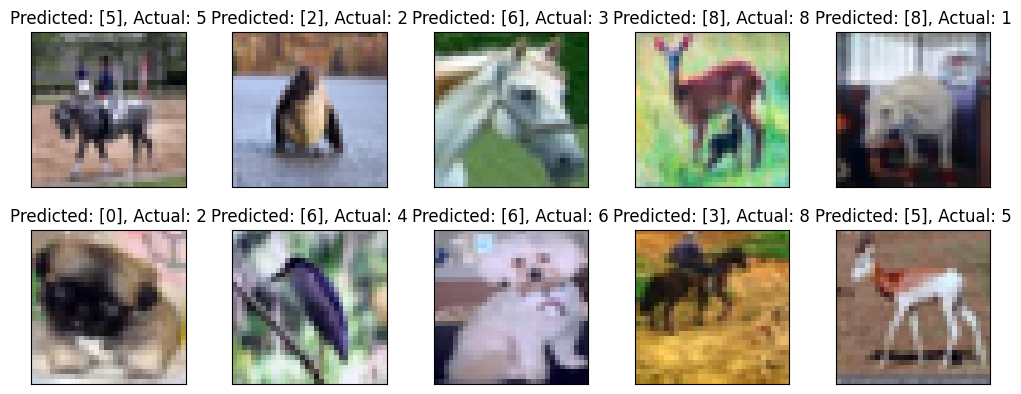

EPOCH: 15


Loss=0.9704874157905579 Batch_id=97 Accuracy=66.94: 100%|██████████| 98/98 [00:16<00:00,  5.99it/s]



Test set: Average loss: 0.8277, Accuracy: 7117/10000 (71.17%)



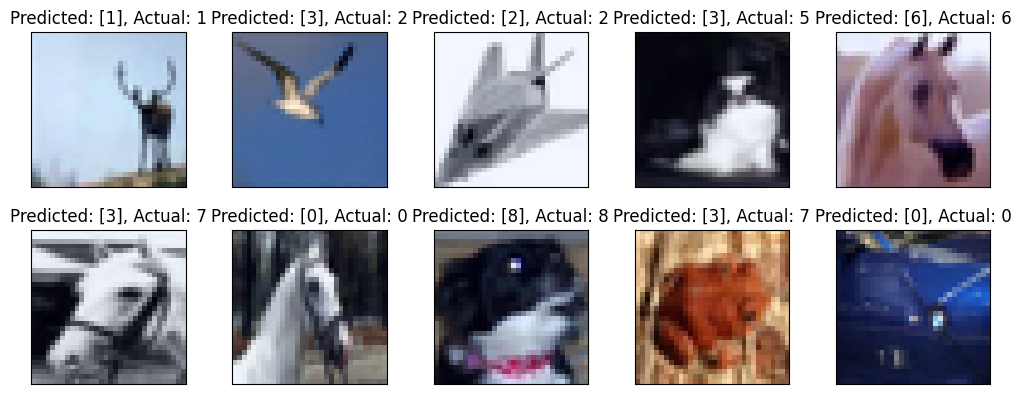

EPOCH: 16


Loss=0.9240244030952454 Batch_id=97 Accuracy=67.50: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]



Test set: Average loss: 0.8197, Accuracy: 7108/10000 (71.08%)



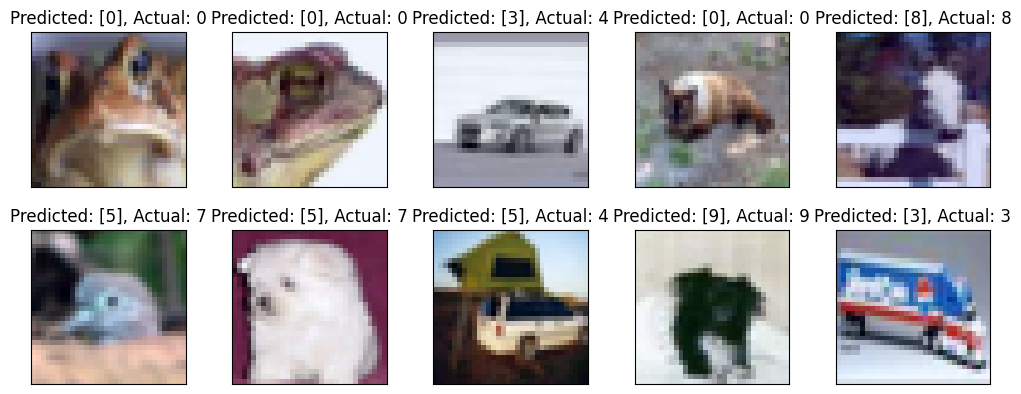

EPOCH: 17


Loss=0.9076898694038391 Batch_id=97 Accuracy=68.04: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]



Test set: Average loss: 0.7823, Accuracy: 7201/10000 (72.01%)



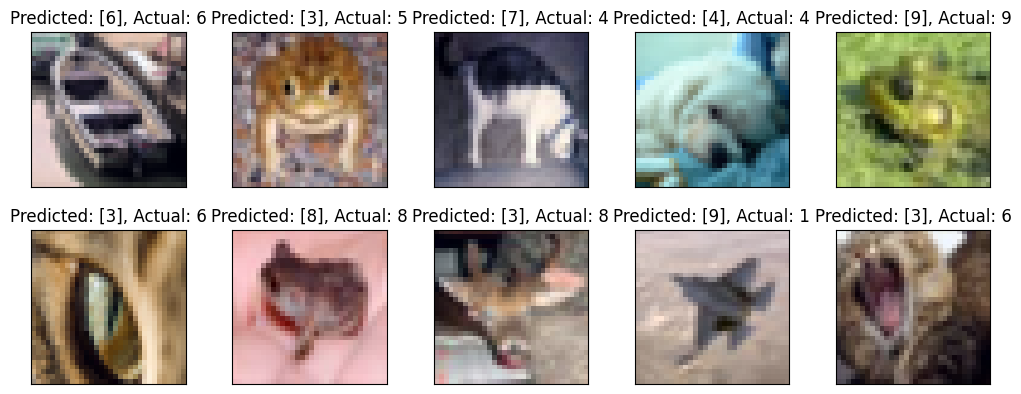

EPOCH: 18


Loss=0.8422904014587402 Batch_id=97 Accuracy=68.55: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]



Test set: Average loss: 0.7789, Accuracy: 7262/10000 (72.62%)



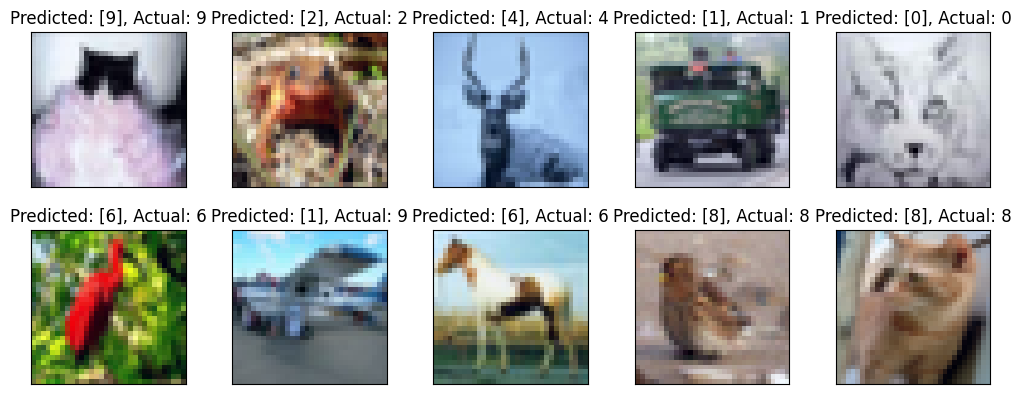

EPOCH: 19


Loss=0.9049556255340576 Batch_id=97 Accuracy=68.99: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]



Test set: Average loss: 0.7406, Accuracy: 7376/10000 (73.76%)



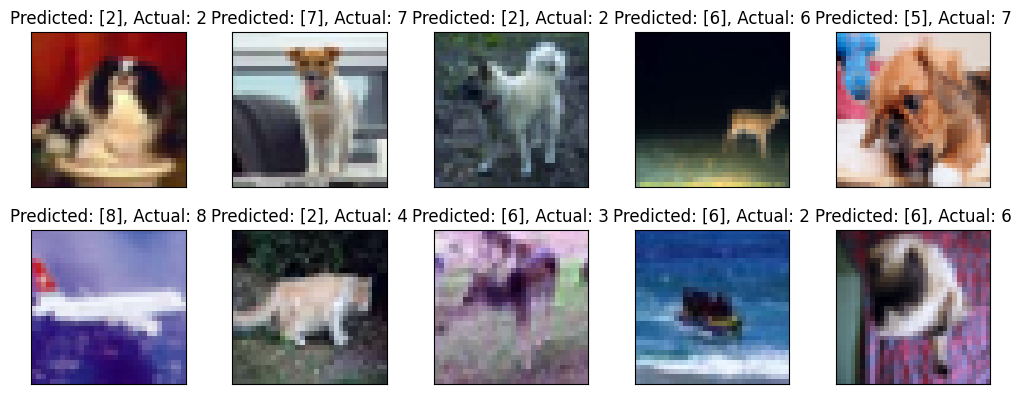

In [33]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)